## 5. 異常検知 (ピーク検出)

高周波帯域 (90-110Hz) のRMSトレンドデータを使って、グリッチを自動検出します。
`gwexpy` の `TimeSeries` には、`scipy.signal.find_peaks` をラップした便利なメソッド `find_peaks()` が実装されています。
これを使うことで、閾値を超えた「ピーク」の時刻と振幅を簡単に取得できます。


In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from gwexpy import TimeSeries

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["axes.unicode_minus"] = False # マイナス記号の文字化け対策


## 1. データの生成（シミュレーション）

1時間分（3600秒）のデータを生成します。サンプリング周波数は 1024 Hz とします。
以下の成分を含めます：
1.  **白色雑音**: ベースとなる環境ノイズ
2.  **ワンダリング・ライン**: 60Hz 付近で周波数がゆっくり変動する正弦波
3.  **グリッチ**: ランダムな時刻に発生する高振幅のバーストノイズ


In [2]:
fs = 1024.0
duration = 3600.0 # 1時間
t = np.linspace(0, duration, int(duration * fs), endpoint=False)

# 1. 白色雑音
np.random.seed(42) # 再現性のためシード固定
noise = np.random.normal(0, 1.0, size=len(t))

# 2. ワンダリング・ライン (60Hz + ゆっくりした揺らぎ)
# 周波数が 59.5Hz ~ 60.5Hz の間をゆっくり往復すると仮定
f_drift = 60.0 + 0.5 * np.sin(2 * np.pi * 0.001 * t) # 周期1000秒の揺らぎ
phase = 2 * np.pi * np.cumsum(f_drift) / fs
line_noise = 2.0 * np.sin(phase)

# 3. グリッチ (突発雑音)
# 5箇所にガウシアンパルスを注入
glitch_times = [600, 1250, 2000, 2800, 3400] # 秒
glitch_signal = np.zeros_like(t)
for gt in glitch_times:
    # 幅 0.5秒のパルス
    glitch_signal += 10.0 * np.exp(-((t - gt)**2) / (2 * 0.1**2)) * np.sin(2 * np.pi * 100 * t)

# 合成
data = noise + line_noise + glitch_signal

# TimeSeries作成
ts = TimeSeries(data, t0=0, sample_rate=fs, name="Sensor Data", unit="V")
print(ts)


TimeSeries([ 1.21650423,  1.20485364,  2.43413719, ...,
            -3.18440669, -1.61170792, -1.45005708]
           unit: V,
           t0: 0.0 s,
           dt: 0.0009765625 s,
           name: Sensor Data,
           channel: None)


## 2. スペクトログラムによる可視化

長時間データの全体像を把握するには、時間領域のプロットだけでは不十分です（データが密集しすぎるため）。
**スペクトログラム**を使うことで、周波数成分の時間変化を一目で確認できます。


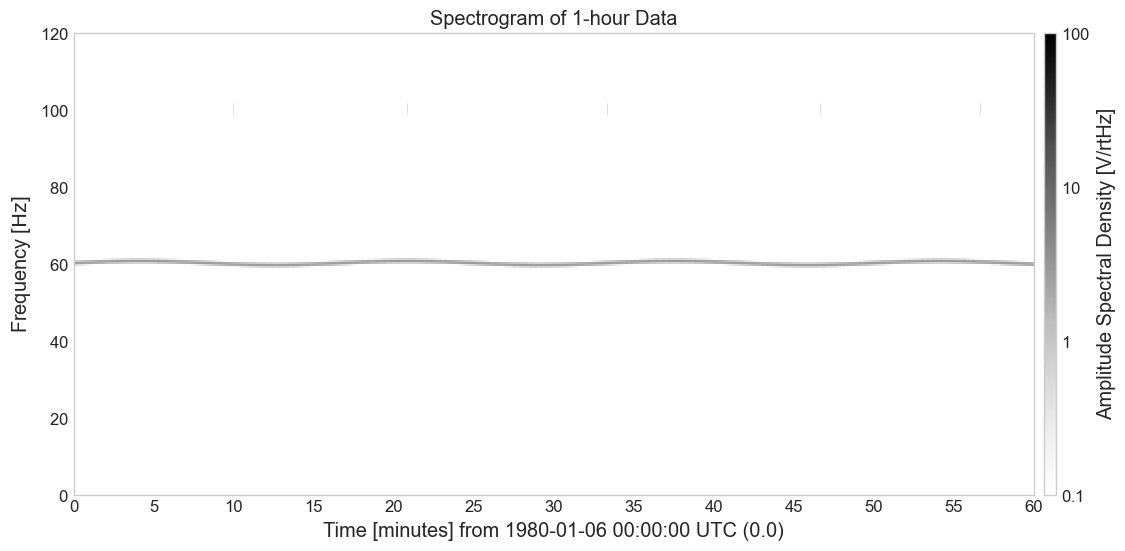

In [3]:
# スペクトログラムの計算
# stride: 時間分解能 (ここでは10秒ごとに計算)
# fftlength: 周波数分解能に関係 (ここでは4秒分のデータでFFT)
spec = ts.spectrogram(stride=2, fftlength=2)

# プロット
# norm="log" で対数カラースケールにして、微弱なノイズも見やすくします
plot = spec.plot(norm="log", vmin=1e-1, vmax=100)
ax = plot.gca()
ax.set_ylim(0, 120) # 120Hzまで表示
ax.set_title("Spectrogram of 1-hour Data")
ax.colorbar(label="Amplitude Spectral Density [V/rtHz]")
plt.show()

# 解説:
# - 60Hz付近に横一本の線が見えますが、拡大すると揺らいでいるのがわかるはずです。
# - 縦に伸びる明るい線が「グリッチ」です。全周波数帯域にパワーが広がっていることがわかります。


## 3. トレンド分析 (Band-Limited RMS)

特定の周波数帯域に着目し、そのパワー（または実効値 RMS）が時間とともにどう変化するかを追跡します。
これを **BLRMS (Band-Limited RMS)** と呼びます。

ここでは、以下の2つの帯域のトレンドを計算してみましょう。
1.  **Line Band**: 58Hz - 62Hz (ラインノイズの変動監視)
2.  **High Frequency Band**: 90Hz - 110Hz (グリッチ検知用、ラインノイズの影響を受けにくい帯域)


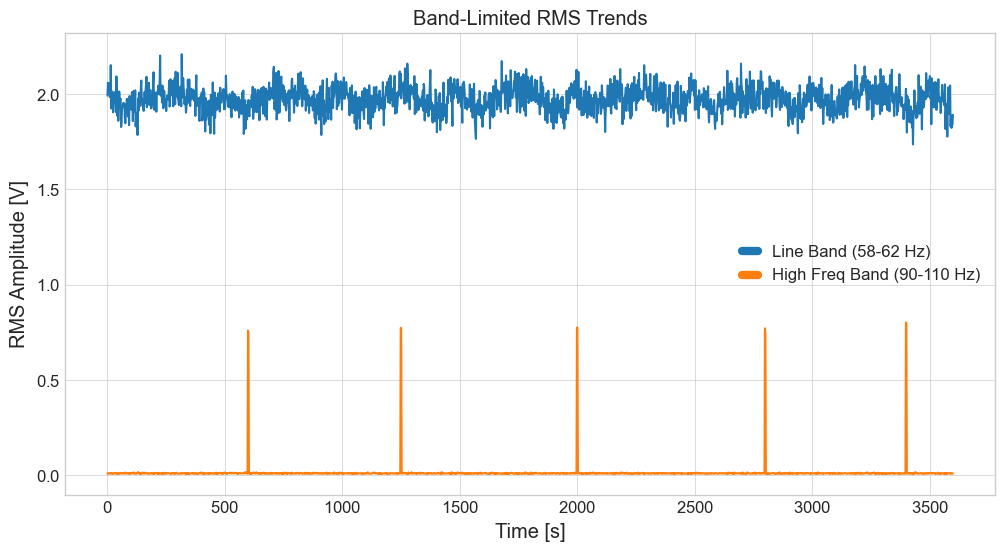

In [4]:
# スペクトログラムから直接、特定の周波数帯域を積分してRMSの時系列を作ることができます。
# .ratio('name')のようなメソッドはないため、周波数軸でスライスして計算します。

# 1. Line Band (58-62 Hz)
# Frequency軸(axis=1)に対して crop して、その方向で積分(sum -> sqrt) します
# gwexpy/gwpy の Spectrogram は .crop(f_min, f_max) で周波数を切り出せます
spec_line = spec.crop_frequencies(58, 62)
# df (周波数分解能) を考慮して積分する必要があります: RMS^2 = sum(ASD^2 * df)
df = spec.df.value
rms_line = np.sqrt((spec_line.value**2).sum(axis=1) * df)

# 2. High Freq Band (90-110 Hz)
spec_high = spec.crop_frequencies(90, 110)
rms_high = np.sqrt((spec_high.value**2).sum(axis=1) * df)

# 時系列としてプロットするための時間軸
t_trend = spec.times.value

plt.figure(figsize=(12, 6))
plt.plot(t_trend, rms_line, label="Line Band (58-62 Hz)")
plt.plot(t_trend, rms_high, label="High Freq Band (90-110 Hz)")
plt.xlabel("Time [s]")
plt.ylabel("RMS Amplitude [V]")
plt.title("Band-Limited RMS Trends")
plt.legend()
plt.show()


## 4. 別アプローチ: ヒルベルト変換によるエンベロープ・瞬時周波数解析

スペクトログラムやBLRMSは「周波数領域」でのアプローチですが、時間分解能が制限されます。
より詳細な信号の挙動（揺らぎ）を捉えたい場合、**「バンドパスフィルタ + ヒルベルト変換」** が有効です。

ここでは、**60Hz付近のラインノイズ** に着目して、その振幅変調（エンベロープ）と周波数変調（瞬時周波数）を抽出してみましょう。
シミュレーションデータには周波数の揺らぎ（ワンダリング）が含まれているため、瞬時周波数のプロットでその様子が確認できるはずです。


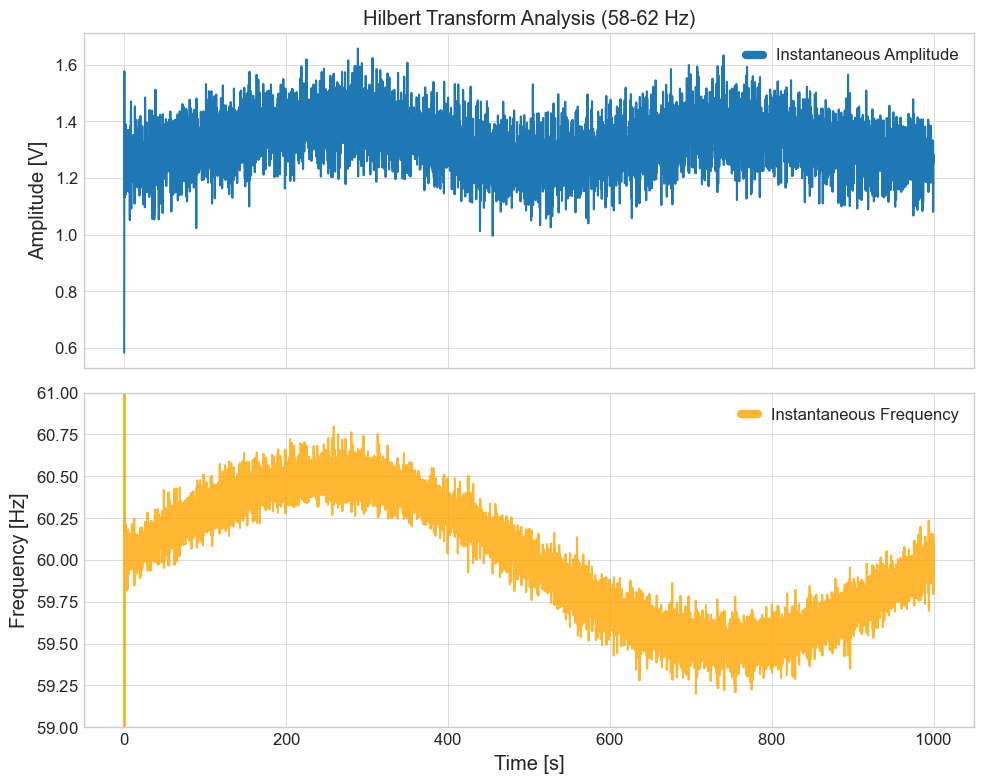

In [5]:
# 1. バンドパスフィルタで帯域を抽出 (58Hz - 62Hz)
# ラインノイズ周辺を取り出します
ts_bandpassed = ts.bandpass(58, 62)

# 2. ヒルベルト変換でエンベロープ（瞬時振幅）を計算
ts_envelope = ts_bandpassed.envelope()

# 3. 瞬時周波数の計算
# 位相の時間微分から周波数を求めます
ts_freq = ts_bandpassed.instantaneous_frequency()

# --- プロット ---
# 最初の1000秒分を表示（ワンダリングの周期が見えるように）
t_start, t_end = 0, 1000
env_crop = ts_envelope.crop(t_start, t_end)
freq_crop = ts_freq.crop(t_start, t_end)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 上段: 瞬時振幅
ax = axes[0]
ax.plot(env_crop.times.value, env_crop.value, label="Instantaneous Amplitude")
ax.set_ylabel("Amplitude [V]")
ax.set_title("Hilbert Transform Analysis (58-62 Hz)")
ax.legend(loc="upper right")
ax.grid(True)

# 下段: 瞬時周波数
ax = axes[1]
ax.plot(freq_crop.times.value, freq_crop.value, color="orange", label="Instantaneous Frequency", alpha=0.8)
ax.set_ylabel("Frequency [Hz]")
ax.set_ylim(59, 61)  # 60Hz周辺を拡大
ax.set_xlabel("Time [s]")
ax.legend(loc="upper right")
ax.grid(True)

plt.tight_layout()
plt.show()

# 解説:
# 瞬時周波数のプロットを見ると、60Hzを中心にゆっくりと周波数が変動している様子（ワンダリング）が確認できます。
# このように、ヒルベルト変換を使うことで、微小な周波数変動も時間解像度よく追跡することができます。


## 5. 異常検知 (ピーク検出)

高周波帯域 (90-110Hz) のRMSトレンドデータを使って、グリッチを自動検出します。
`gwexpy` の `TimeSeries` には、`scipy.signal.find_peaks` をラップした便利なメソッド `find_peaks()` が実装されています。
これを使うことで、閾値を超えた「ピーク」の時刻と振幅を簡単に取得できます。


Detected 5 anomaly events.
Anomaly times (approx): [ 598. 1248. 1998. 2798. 3398.]


<Figure size 1200x400 with 0 Axes>

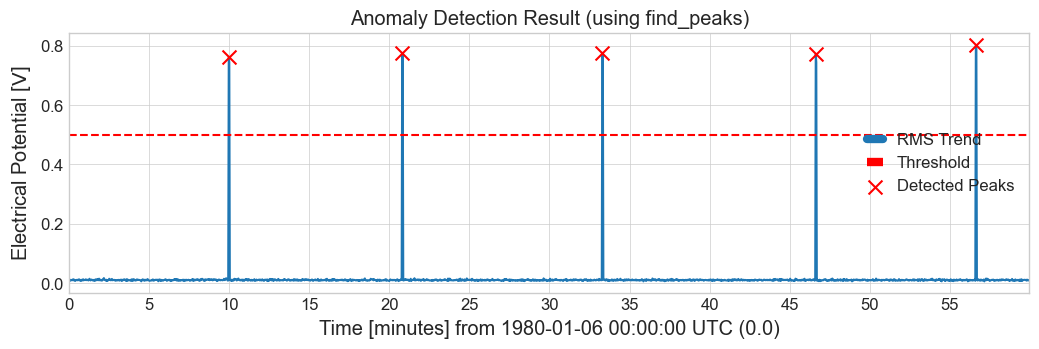

In [7]:
# 高周波バンドのRMSデータを TimeSeries オブジェクトに変換
ts_rms_high = TimeSeries(rms_high, times=spec.times, name="High Band RMS", unit="V")

# 閾値の設定
threshold = 0.5

# 異常検知: find_peaks メソッドを使用
# height: ピークの最小高さ (閾値)
# distance: ピーク間の最小距離 (サンプル数)。近接するピークをまとめるのに有効です。
# ここでは、データの間隔が2秒なので、distance=10 とすると 20秒以内の近接ピークは無視されます。
peaks, properties = ts_rms_high.find_peaks(height=threshold, distance=10)

detected_times = peaks.times.value
print(f"Detected {len(detected_times)} anomaly events.")
print("Anomaly times (approx):", detected_times)

# 検出結果をプロット
plt.figure(figsize=(12, 4))
plot = ts_rms_high.plot(label="RMS Trend")
ax = plot.gca()
ax.axhline(threshold, color="red", linestyle="--", label="Threshold")

# 検出されたピークをプロット
# peaks は TimeSeries オブジェクトなので、そのまま plot() できますが、
# ここでは元データの上に散布図として重ねます
ax.scatter(detected_times, peaks.value, color="red", marker="x", s=100, label="Detected Peaks", zorder=5)

ax.set_title("Anomaly Detection Result (using find_peaks)")
ax.legend()
plt.show()

# 正解の glitch_times と比較
# glitch_times = [600, 1250, 2000, 2800, 3400]
